In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
key = jax.random.PRNGKey(0)

In [3]:
def getLine(phi, theta, r_max = 10, N = 2000):
    r = jnp.linspace(-r_max, r_max, num = N)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

## Potential Energy

In [4]:
E_f = -2.900597922920

R = jnp.array([[0,0,0]])                      # nuclei positions
k = jnp.array([2.])                          # potential energy coefficients (nuclear charge)

In [5]:
def calc_E_nuc():
    acc = 0
    for i in range(len(R)):
        for j in range(i + 1, len(R)):
            d = jnp.sqrt(jnp.sum((R[i] - R[j])**2))
            acc += k[i] * k[j] / d

    return acc

E_nuc = calc_E_nuc()

In [47]:
#
# The potential energy function depending on the coordinates
#
def potential(x, params):
    x1_ = x[:, 0:3]
    x2_ = x[:, 3:6]

    x1 = jnp.expand_dims(x1_, axis = 1)
    r1 = jnp.expand_dims(R,  axis = 0)
    d1 = jnp.sqrt(jnp.sum((x1 - r1)**2, axis = 2))

    x2 = jnp.expand_dims(x2_, axis = 1)
    r2 = jnp.expand_dims(R,  axis = 0)
    d2 = jnp.sqrt(jnp.sum((x2 - r2)**2, axis = 2))

    dee = jnp.sqrt(jnp.sum((x1_-x2_)**2, axis = 1))

    p = -jnp.sum(k/d1, axis = 1) - jnp.sum(k/d2, axis = 1) + E_nuc + 1/dee
    return p


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1.,1.], potential = potential)

## Construct Neural Network

In [48]:
def act(x):
    return nn.softplus(x)

In [49]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(10, name="dense2", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(y)
        x = nn.Dense(20, name="dense3", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(10, name="dense4", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x) + y

        a = nn.Dense(1, name="dense5", param_dtype="float64", bias_init=jax.random.normal)(x)
        a = -act(a)

        # b = nn.Dense(1, name="dense6", param_dtype="float64", bias_init=jax.random.normal)(x)

        # return jnp.squeeze(a + jnp.log(b + 0.j))
        return jnp.squeeze(a)

## Construct Ansatz

In [50]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (6,))

        self.nn = NN()

        self.r_eps = 0


    def init_param(self, key):
        a = jax.random.normal(key)**2
        key, key2 = jax.random.split(key)
        b = jax.random.normal(key)**2

        nn_param = self.nn.init(key2, jnp.empty((3,)))

        return {"alpha": a, "nn": nn_param}
    
    def eval_nn(self, parameters, x):
        x1_ = x[:, 0:3]
        x2_ = x[:, 3:6]

        r1 = jnp.sqrt((x1_[:, 0])**2 + x1_[:, 1]**2 + x1_[:, 2]**2 + self.r_eps)
        r2 = jnp.sqrt((x2_[:, 0])**2 + x2_[:, 1]**2 + x2_[:, 2]**2 + self.r_eps)

        dot = jnp.sum(x1_ * x2_, axis = -1)

        coord = jnp.stack((r1, r2, dot), axis = 1)
        coord2 = jnp.stack((r2, r1, dot), axis = 1)

        return self.nn.apply(parameters["nn"], coord) + self.nn.apply(parameters["nn"], coord2)

    
    def calc_logpsi(self, parameters, x):
        x1_ = x[:, 0:3]
        x2_ = x[:, 3:6]

        r1 = jnp.sqrt((x1_[:, 0])**2 + x1_[:, 1]**2 + x1_[:, 2]**2 + self.r_eps)
        r2 = jnp.sqrt((x2_[:, 0])**2 + x2_[:, 1]**2 + x2_[:, 2]**2 + self.r_eps)


        # inter-electron distance
        ree = jnp.sqrt(jnp.sum((x1_ - x2_)**2, axis = 1))


        # dihydrogen Ansatz for both electrons
        psi1 = jnp.exp(-0.5*parameters["alpha"]*r1)
        psi2 = jnp.exp(-0.5*parameters["alpha"]*r2)

        # electron-electron cusp
        chi = -0.5*1/(1+ree)

        # electron-exchange-symmetric correlation term (neural network)
        nn_out = self.eval_nn(parameters, x)

        return jnp.log(psi1) + jnp.log(psi2) + nn_out + chi

In [51]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

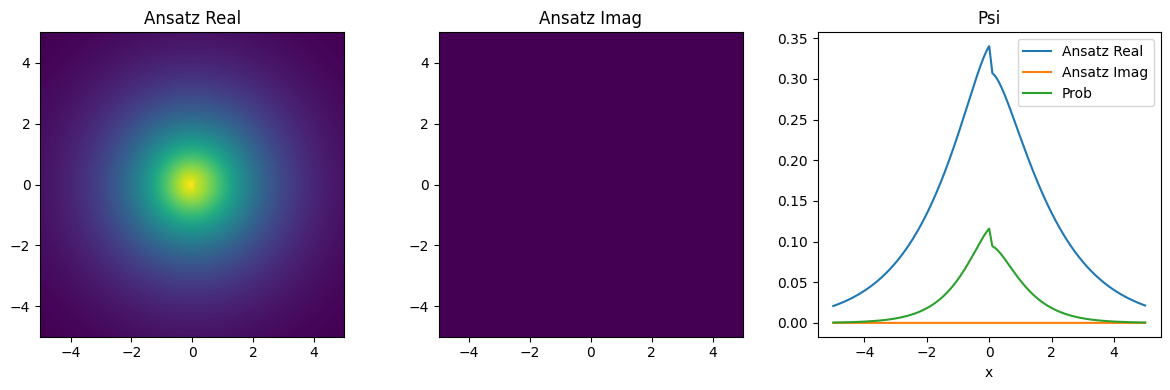

In [52]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

N = 1000
xs = jnp.linspace(-5, 5, num = N)
ys = jnp.linspace(-5, 5, num = N)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

e0pos = jnp.array([0.1,0.,0.])

ex = jnp.repeat(jnp.repeat(e0pos[jnp.newaxis, :], N, 0)[jnp.newaxis, :], N, 0)
fullim = jnp.concatenate((im, ex), axis = 2)

res = ansatz.calc_psi(param, fullim.reshape(-1, 6)).reshape(xss.shape)


axs[0].imshow(res.real, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz Real")


axs[1].imshow(res.imag, extent = [-5, 5, -5, 5])
axs[1].set_title("Ansatz Imag")

# res = ansatz.eval_nn(param, fullim.reshape(-1, 6)).reshape(xss.shape).real
# axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
# axs[1].set_title("Neural Network")

r, line = getLine(0, jnp.pi/2, r_max=5)
ex = jnp.repeat(e0pos[jnp.newaxis, :], r.shape[0], 0)
fullline = jnp.concatenate((line, ex), 1)
psi = ansatz.calc_psi(param, fullline)
nn_out = ansatz.eval_nn(param, fullline)

axs[2].plot(r, psi.real, label = "Ansatz Real")
axs[2].plot(r, psi.imag, label = "Ansatz Imag")
axs[2].plot(r, jnp.abs(psi)**2, label = "Prob")
# axs[2].plot(r, nn_out, label = "NN output")
# axs[2].set_yscale("log")
axs[2].set_title("Psi")
axs[2].legend()
axs[2].set_xlabel("x")

f.tight_layout()

## Sampler

In [63]:
class SymmetrySampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mirrorprob = 0.01

        var = jax.random.normal(key, shape = self.shape) * jnp.sqrt(self.variance)
        inv = -element

        decide = jax.random.uniform(key)

        proposal = jnp.where(decide < mirrorprob, inv, element + var)

        return subkey, proposal
sampler = SymmetrySampler(ansatz, 0.10)
subsampling = 10
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (6,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

## Optimisation

In [64]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc.real)
    dE = jnp.std(E_loc.real)

    logpsi_red = lambda parameters: jnp.conjugate(orbital.calc_logpsi(parameters, samples))
    y, v = netket.jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = netket.jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1/N*x, b)

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)

    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = netket.jax.vjp(f, parameters)[1](e)[0]
    return  jax.tree_util.tree_map(lambda v: 1/N**2 * a * v, b)

@partial(jax.jit, static_argnames=['orbital'])
def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return jax.tree_util.tree_map(lambda a,b: jnp.real(a-b), s1, s2)
eps = 1e-4

def reg_S(ansatz, param, samples, v):
    u = eval_S(ansatz, param, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a + eps * b, u, v)

@jax.jit
def calc_natural_grad(param, samples):
    A = lambda v: reg_S(ansatz, param, samples, v)
    b, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)
    return jax.scipy.sparse.linalg.cg(A, b)[0], E, dE

In [65]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": []}
param = ansatz.init_param(key)

In [70]:
N = 8000
epoch = 100

# define
optimizer = optax.sgd(learning_rate=0.05)

# initialise
optimizer_state = optimizer.init(param)

In [71]:
for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_natural_grad(param, samples)
    # grad, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


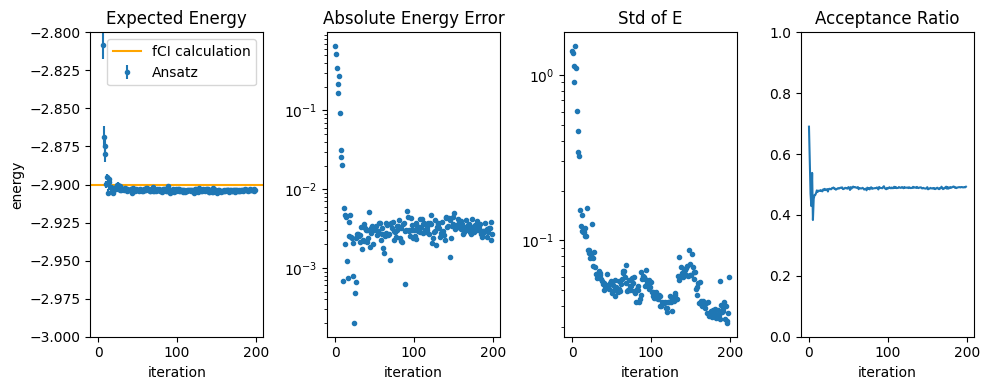

In [73]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 4, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")
ax[0].axhline(E_f, label = "fCI calculation", color = "orange")
ax[0].legend(loc = "upper right")
ax[0].set_ylim(-3, -2.8)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("energy")

ax[1].scatter(i, jnp.abs(numpy_stats["E"]-E_f) , label = "error", marker = ".")
ax[1].set_title("Absolute Energy Error")
ax[1].set_yscale("log")
ax[1].set_xlabel("iteration")
# ax[1].set_xlim(i[-20], i[-1])

ax[2].scatter(i, stats["dE"], marker = ".")
ax[2].set_title("Std of E")
ax[2].set_yscale("log")
ax[2].set_xlabel("iteration")

ax[3].plot(stats["ratio"])
ax[3].set_ylim(0,1)
ax[3].set_title("Acceptance Ratio")
ax[3].set_xlabel("iteration")

f.tight_layout()

# n_param = sum(x.size for x in jax.tree_util.tree_leaves(param))


## Energy Inspection

Text(0.5, 1.0, 'local energy')

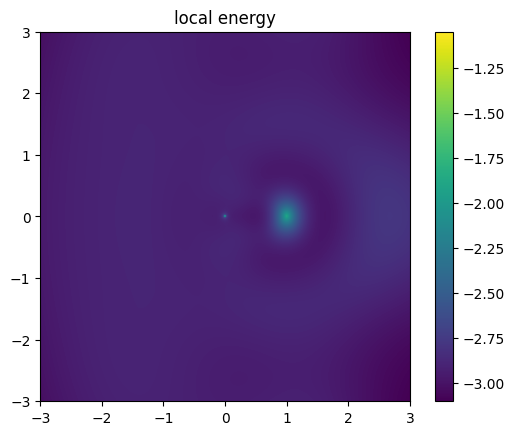

In [74]:
N = 1000
l = 3
xs = jnp.linspace(-l, l, num = N)
ys = jnp.linspace(-l, l, num = N)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

e0pos = jnp.array([1.,0.,0.])

ex = jnp.repeat(jnp.repeat(e0pos[jnp.newaxis, :], N, 0)[jnp.newaxis, :], N, 0)
fullim = jnp.concatenate((im, ex), axis = 2)

hloc = hamiltonian.calc_H_loc(ansatz, param,  fullim.reshape(-1, 6)).reshape(xss.shape)


plt.imshow(hloc, extent = [-l, l, -l, l])
plt.colorbar()
plt.title("local energy")

In [75]:
N = 6000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples).real
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error:", (jnp.mean(H_loc) - E_f)/jnp.abs(E_f))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.4923666666666667
Expected Energy: -2.9035894947364445 +/- 0.0005043127726234869
Energy Error: -0.0010313638415051414
Std of Expected Energy: 0.039063899393009055


In [76]:
E_f

-2.90059792292

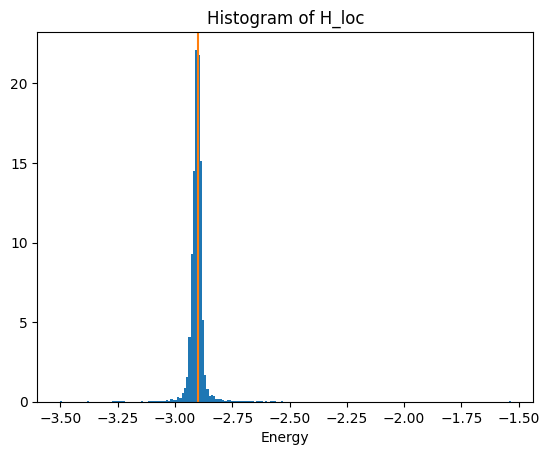

In [78]:
plt.hist(H_loc, bins=200, density=True)
plt.axvline(E_f, color = "C1")
# plt.ylim(0,20)
plt.title("Histogram of H_loc")
plt.xlabel("Energy")
pass